In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

In [2]:
df = pd.read_csv('../data/processed/merged_financials_news.csv')

In [3]:
df.head()

symbol        date  Issuance Of Capital Stock  marketCap  \
0  000270.KS  2024-12-31                  -0.168666   1.301788   
1    0005.HK  2024-12-31                  22.098422   0.484661   
2  000660.KS  2024-12-31                 580.606623   1.635445   
3  005380.KS  2024-12-31                  -0.168666   1.375980   
4  005930.KS  2024-12-31                  -0.168666   1.908610   

   price_to_earnings  Purchase Of Business  Share Issued  Change In Payable  \
0          -0.458283           -629.585163     -0.341900         594.104251   
1           1.312074             -5.108643      1.545893           2.694967   
2          -0.913102            -10.581392     -0.063262        -830.309496   
3          -0.455416           -926.572919     -0.523138         627.130386   
4          -0.267801            -63.485044      1.066336       -1157.796403   

   Change In Inventory  Sale Of Business  ...  region_sub_saharan_africa  \
0         -1207.471565          0.938057  ...                        0.0   
1            -3.810179          0.847369  ...                        0.0   
2           134.656164          0.977396  ...                        0.0   
3          -935.423848          0.891267  ...                        0.0   
4          2050.753160          1.038735  ...                        0.0   

   companySize_Large-Cap  companySize_Mid-Cap  companySize_Small-Cap  \
0                    1.0                  0.0                    0.0   
1                    0.0                  0.0                    1.0   
2                    1.0                  0.0                    0.0   
3                    1.0                  0.0                    0.0   
4                    1.0                  0.0                    0.0   

                                        cleaned_text  \
0  ['The Integrated Greenhouse Gas Information Sy...   
1  ['We recently published a list of 12 Best ADR ...   
2  ['According to a new report from SP Global, th...   
3  ['The series, now viewable on YouTube, present...   
4  ['The HVAC System Market is set to grow by USD...   

                                       raw_sentiment  sentiment_ratio_all  \
0  [{'label': 'positive', 'score': 0.708621323108...            -0.142857   
1  [{'label': 'negative', 'score': 0.481453657150...            -0.500000   
2  [{'label': 'positive', 'score': 0.569136857986...             0.428571   
3  [{'label': 'neutral', 'score': 0.7179769873619...             0.166667   
4  [{'label': 'neutral', 'score': 0.8837077021598...             0.000000   

   sentiment_ratio_extremes  weighted_sentiment_avg  \
0                 -0.333333               -0.035744   
1                 -1.000000               -0.317086   
2                  1.000000                0.256201   
3                  1.000000                0.122389   
4                       NaN                0.000000   

   weighted_sentiment_norm_conf  
0                     -0.061384  
1                     -0.410726  
2                      0.386590  
3                      0.174893  
4                      0.000000  

[5 rows x 87 columns]

# Data Preprocessing

In [4]:
df.columns[df.isna().any()].tolist()

['sentiment_ratio_extremes']

In [5]:
# null values in the sentiment columns are due to zero division errors, so they can be filled with 0
df['sentiment_ratio_extremes'] = df['sentiment_ratio_extremes'].fillna(0)
df.columns[df.isna().any()].tolist()

[]

In [6]:
# drop the remaining metadata columns
df_clean = df.drop(columns=['date', 'symbol', 'cleaned_text', 'raw_sentiment'])

In [7]:
# create a combined stratification variable from region and size
def process_strata(x, df):
    return '_'.join([
        next((col.replace('region_', '') for col in df.columns if col.startswith('region_') and x[col] == 1), ''),
        next((col.replace('companySize_', '') for col in df.columns if col.startswith('companySize_') and x[col] == 1), '')
    ])

In [8]:
df_clean['strat_var'] = df_clean.apply(lambda x: process_strata(x, df_clean), axis=1)

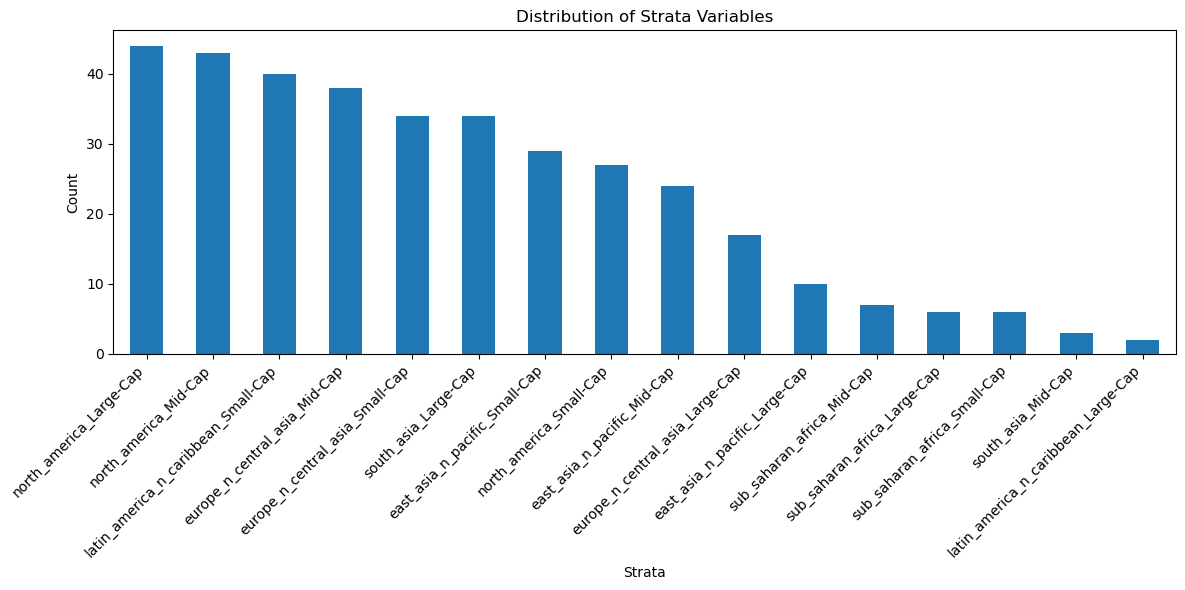

In [9]:
# Create figure with larger size
plt.figure(figsize=(12, 6))

# Plot value counts
df_clean['strat_var'].value_counts().plot(kind='bar')

# Customize the plot
plt.title('Distribution of Strata Variables')
plt.xlabel('Strata')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Data Construction

## Baseline Data Definition

This represents a less diverse, status quo scenario. This could be:
- the dataset in its original, imbalanced form 
- a deliberately constrained subset. 

In line with common ESG datasets that are skewed towards large companies in developed regions, we construct the baseline to have a limited diversity in region and size. For example, the baseline training data may be dominated by North American and European firms (the most represented in typical ESG data) and by large-cap companies, with fewer or no examples from other regions or smaller firms. This baseline reflects a case where selection bias is present 

In [ ]:
# construct baselines with limited diversity and constrained regions
baseline = df_clean.copy()
baseline_constrained = df_clean.loc[(df_clean['companySize_Large-Cap'] == 1 ) & ((df_clean['region_north_america'] == 1) | (df_clean['region_europe_n_central_asia'] == 1))]

In [ ]:
baseline.shape, baseline_constrained.shape

## Diversified Dataset

The diversified dataset is constructed to be globally representative, incorporating a wide range of regions and company sizes. We sample or weight the data such that all major geographic regions (e.g. North America, Europe & Central Asia, East Asia & Pacific, Latin America, Middle East & Africa, South Asia, Sub-Saharan Africa) and firm sizes (small-cap, mid-cap, large-cap) are included in appreciable proportions

In [ ]:
def build_diversified_dataset(df, strata_key="strat_var", 
                              target_sample_size: str = 'max',
                              random_state: int = 42):
    """
    Returns a diversified DataFrame where each group defined by strata_cols
    has been up‑sampled or down‑sampled to the same size.

    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed DataFrame (no date columns, all features encoded).
    strata_cols : tuple of str
        Column names to define each stratum, e.g. ('region', 'companySize').
    target_sample_size : 'max' | 'min' | int
        - 'max': up-sample all groups to the size of the largest group.
        - 'min': down-sample all groups to the size of the smallest group.
        - int: sample exactly this many rows per group (must be <= max and >= min).
    random_state : int
        For reproducibility of sampling.

    Returns
    -------
    pd.DataFrame
        Diversified dataset.
    """
    
    # Compute counts per stratum
    counts = df[strata_key].value_counts()
    
    # Determine target sampling size
    if target_sample_size == 'max':
        n_target = counts.max()
    elif target_sample_size == 'min':
        n_target = counts.min()
    elif isinstance(target_sample_size, int):
        n_target = target_sample_size
        if n_target < counts.min() or n_target > counts.max():
            raise ValueError(f"target_sample_size must be between {counts.min()} and {counts.max()}")
    else:
        raise ValueError("target_sample_size must be one of {'max','min'} or an integer")
    
    # Resample each group
    frames = []
    for stratum, grp_count in counts.items():
        grp = df[df[strata_key] == stratum]
        if grp_count > n_target:
            # Down‑sample without replacement
            grp_resampled = grp.sample(n=n_target, replace=False, random_state=random_state)
        elif grp_count < n_target:
            # Up‑sample with replacement
            grp_resampled = grp.sample(n=n_target, replace=True, random_state=random_state)
        else:
            # Already at target size
            grp_resampled = grp
        frames.append(grp_resampled)
    
    diversified = pd.concat(frames, axis=0).reset_index(drop=True)
    # diversified.drop(columns=strata_key, inplace=True)
    return diversified

In [ ]:
# Option A: up‑sample minority strata to match the largest group
diversified_max = build_diversified_dataset(df_clean, target_sample_size='max')
print("Diversified (to max) shape:", diversified_max.shape)
# print(diversified_max.groupby('strat_var').size())

# Option B: down‑sample majority strata to match the smallest group
diversified_min = build_diversified_dataset(df_clean, target_sample_size='min')
print("Diversified (to min) shape:", diversified_min.shape)
# print(diversified_min.groupby('strat_var').size())

# Option C: choose a custom size, e.g. median group size
median_n = int(df_clean.groupby('strat_var').size().median())
diversified_med = build_diversified_dataset(df_clean, target_sample_size=median_n)
print(f"Diversified (to median={median_n}) shape:", diversified_med.shape)
# print(diversified_med.groupby('strat_var').size())

# Experimental Setup

## Within-Sample Evaluation

Traditional evaluation where training and test data are drawn from the same distribution. Data is split into training and test sets using stratified random sampling.
Stratification is done on key group variables (region and size) so that the test set contains a similar distribution of regions and company sizes as the training set.

This within-sample test measures how well the model fits the data it’s generally expected to see (i.i.d. scenario) and provides a baseline performance on familiar contexts.

In [ ]:
def within_sample_eval(df, strata_key="strat_var", test_size=0.2, random_state=42, show_stats=False):
    """
    Performs stratified train/test split while maintaining distribution of region and size.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing features and strata_key
    strata_key : str
        Column name for stratification variable
    test_size : float
        Proportion of dataset to include in the test split
    random_state : int
        Random seed for reproducibility
    show_stats : bool
        Whether to print distribution statistics
        
    Returns
    -------
    dict
        Dictionary containing train/test splits for the 
    """
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    splits = {}
    
    for train_idx, test_idx in splitter.split(df, df[strata_key]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()
        
        if show_stats:
            print("\nDataset sizes:")
            print(f"Training set: {len(train_df)} samples")
            print(f"Test set: {len(test_df)} samples")
            
            # Compare distributions
            print("\nStrata distribution:")
            train_dist = train_df[strata_key].value_counts(normalize=True)
            test_dist = test_df[strata_key].value_counts(normalize=True)
            
            comparison = pd.DataFrame({
                'Train %': train_dist * 100,
                'Test %': test_dist * 100
            }).round(2)
            print(comparison)
            
        # Drop stratification variable after checking distributions
        train_df = train_df.drop(columns=strata_key)
        test_df = test_df.drop(columns=strata_key)
        
        splits['within_sample'] = {
            'train': train_df,
            'test': test_df,
            'train_size': len(train_df),
            'test_size': len(test_df)
        }
        
    return splits

In [ ]:
# Example usage:
print("Baseline Dataset Within-Sample Split:")
baseline_splits = within_sample_eval(baseline, show_stats=True)

print("\nDiversified Dataset Within-Sample Split:")
diversified_splits = within_sample_eval(diversified_med, show_stats=True)

# Access the splits using the dictionary structure
train_data = baseline_splits['within_sample']['train']
test_data = baseline_splits['within_sample']['test']

## Region Hold Out

In each run, we exclude all companies from a particular geographic region from the training set, and reserve them as a hold-out test set. For instance, we might train a model using data from all regions except East Asia & Pacific, and then test it on the East Asia & Pacific companies’ data to see how well the model generalizes to that unseen region. 

In [ ]:
def region_holdout_eval(df, strata_key="strat_var", show_stats=False):
    """
    Performs leave-one-region-out evaluation by iteratively holding out each region
    as a test set and training on the remaining regions.
    
    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed DataFrame containing region columns and strata_key
    strata_key : str
        Column name for stratification variable
        
    Returns
    -------
    dict
        Dictionary containing train/test splits for each held-out region
    """
    # Get all region columns
    region_cols = [col for col in df.columns if col.startswith('region_')]
    holdout_splits = {}
    
    # Perform leave-one-region-out splits
    for region_col in region_cols:
        region_name = region_col.replace('region_', '')
        
        # Create train/test split
        test_mask = df[region_col] == 1
        train_df = df[~test_mask].copy()
        test_df = df[test_mask].copy()
        
        # Drop stratification variable if present
        if strata_key in train_df.columns:
            train_df = train_df.drop(columns=[strata_key])
            test_df = test_df.drop(columns=[strata_key])
            
        holdout_splits[region_name] = {
            'train': train_df,
            'test': test_df,
            'train_size': len(train_df),
            'test_size': len(test_df)
        }
        
        print(f"\nHold-out region: {region_name}")
        print(f"Training set size: {len(train_df)}")
        print(f"Test set size: {len(test_df)}")
        
        # Print region distribution in training set
        if show_stats:
            print("\nRegion distribution in training set:")
            for r in region_cols:
                pct = train_df[r].mean() * 100
                if pct > 0:
                    print(f"{r.replace('region_', '')}: {pct:.1f}%")
                    
    return holdout_splits

## Company-Size Hold Out

We categorize companies into size classes (Small-Cap, Mid-Cap, Large-Cap, as provided in the dataset) and train models excluding one category. For example, train on only large and mid-cap firms, and test on all the small-cap firms (which the model has never seen). 

In [ ]:
def size_holdout_eval(df, strata_key="strat_var", show_stats=False):
    """
    Performs leave-one-size-out evaluation by iteratively holding out each company size
    as a test set and training on the remaining sizes.
    
    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed DataFrame containing company size columns and strata_key
    strata_key : str
        Column name for stratification variable
        
    Returns
    -------
    dict
        Dictionary containing train/test splits for each held-out size category
    """
    # Get all company size columns
    size_cols = [col for col in df.columns if col.startswith('companySize_')]
    holdout_splits = {}
    
    # Perform leave-one-size-out splits
    for size_col in size_cols:
        size_name = size_col.replace('companySize_', '')
        
        # Create train/test split
        test_mask = df[size_col] == 1
        train_df = df[~test_mask].copy()
        test_df = df[test_mask].copy()
        
        # Drop stratification variable if present
        if strata_key in train_df.columns:
            train_df = train_df.drop(columns=[strata_key])
            test_df = test_df.drop(columns=[strata_key])
            
        holdout_splits[size_name] = {
            'train': train_df,
            'test': test_df,
            'train_size': len(train_df),
            'test_size': len(test_df)
        }
        
        print(f"\nHold-out size: {size_name}")
        print(f"Training set size: {len(train_df)}")
        print(f"Test set size: {len(test_df)}")
        
        # Print size distribution in training set
        if show_stats:
            print("\nSize distribution in training set:")
            for s in size_cols:
                pct = train_df[s].mean() * 100
                if pct > 0:
                    print(f"{s.replace('companySize_', '')}: {pct:.1f}%")
            
            # Also show region distribution to check for any bias
            region_cols = [col for col in df.columns if col.startswith('region_')]
            print("\nRegion distribution in training set:")
            for r in region_cols:
                pct = train_df[r].mean() * 100
                if pct > 0:
                    print(f"{r.replace('region_', '')}: {pct:.1f}%")
    
    return holdout_splits

In [ ]:
# Create holdout splits for both baseline and diversified datasets
print("Baseline Dataset Size Holdouts:")
baseline_size_holdouts = size_holdout_eval(baseline, show_stats=True)

print("\nDiversified Dataset Size Holdouts:")
diversified_size_holdouts = size_holdout_eval(diversified_med, show_stats=True)

# Example: Using Small-Cap holdout
size = 'Small-Cap'
train_data = diversified_size_holdouts[size]['train']
test_data = diversified_size_holdouts[size]['test']